<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
<center>
Авторы материала: Виталий Радченко (YouScan) и Юрий Кашницкий (Mail.Ru Group).

Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №5
## <center> Случайный лес и логистическая регрессия в задачах кредитного скоринга и классификации отзывов к фильмам

#### Нашей главной задачей будет построение и настройка моделей для задач кредитного скоринга и анализа отзывов к фильмам. Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1s17pqYJ1kUez7F_c0qHDLYpucL5XMs9QWK4JgTfxk9E/edit).

Но для разминки решите первое задание.

**<font color='red'>Задание 1.</font>** В зале суда есть 7 присяжных, каждый из них по отдельности с вероятностью 80% может правильно определить, виновен подсудимый или нет. С какой вероятностью присяжные все вместе вынесут правильный вердикт, если решение принимается большинством голосов?

**<font color='red'>Варианты ответа:</font>**
- 20.97%
- 80.00%
- 83.70%
- 96.66%

Теперь перейдем непосредственно к машинному обучению.

#### Данные по кредитному скорингу представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	– Человек имел долгие просрочки выплат платежей за 2 года; бинарный признак

##### Независимые признаки
* age	                         – Возраст заёмщика кредитных средств (число полных лет); тип – integer
* NumberOfTime30-59DaysPastDueNotWorse	– Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней (но не больше) в течение последних двух лет; тип -	integer
* DebtRatio –	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип – float
* MonthlyIncome	– Месячный доход в долларах; тип –	float
* NumberOfTimes90DaysLate – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип –	integer
* NumberOfTime60-89DaysPastDueNotWorse –	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней (но не больше) в течение последних двух лет; тип – integer
* NumberOfDependents – Число человек в семье кредитозаёмщика; тип –	integer

In [1]:
from scipy.special import comb

acc = 0;
for i in range(4,8):
    acc += comb(7, i)*(0.8 ** i)*(0.2 ** (7-i))
    
acc

0.9666560000000004

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Напишем функцию, которая будет заменять значения NaN на медиану в каждом столбце таблицы. 

In [16]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Считываем данные

In [17]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Рассмотрим типы считанных данных

In [18]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Посмотрим на распределение классов в зависимой переменной

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

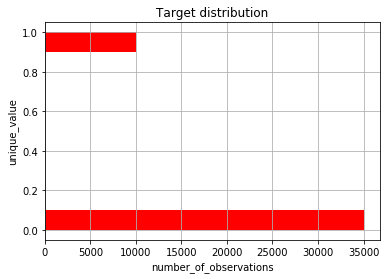

In [19]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

Выберем названия всех признаков, кроме прогнозируемого

In [20]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Применяем функцию, заменяющую все значения NaN на медианное значение соответствующего столбца.

In [21]:
table = impute_nan_with_median(data)

Разделяем целевой признак и все остальные – получаем обучающую выборку. 

In [22]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

Выведем версии основных библиотек – результат `GridSearchCV`, например, может отличаться в разных версиях `sklearn` даже при фиксированном `random_state`.

In [15]:
#!pip install watermark
%load_ext watermark

In [23]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

UsageError: Line magic function `%watermark` not found.


# Бутстрэп

**<font color='red'>Задание 2.</font>** Сделайте интервальную оценку (на основе бутстрэпа) среднего дохода (MonthlyIncome) клиентов, просрочивших выплату кредита, и отдельно – для вовремя заплативших. Стройте 90% доверительный интервал. Найдите разницу между нижней границей полученного интервала для не просрочивших кредит и верхней границей – для просрочивших. 
То есть вас просят построить 90%-ые интервалы для дохода "хороших" клиентов $[good\_income\_lower, good\_income\_upper]$ и для "плохих" – $[bad\_income\_lower, bad\_income\_upper]$ и найти разницу $good\_income\_lower - bad\_income\_upper$.

Используйте пример из [статьи](https://habrahabr.ru/company/ods/blog/324402/). Поставьте `np.random.seed(17)`. Округлите ответ до целых.

**<font color='red'>Варианты ответа:</font>**
- 345
- 425
- 585
- 655

In [24]:
# Ваш код здесь

def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    np.random.seed(17)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
loyal_income = table[table['SeriousDlqin2yrs'] == 0]['MonthlyIncome'].values
nonloyal_income= table[table['SeriousDlqin2yrs'] == 1]['MonthlyIncome'].values

# ставим seed для воспроизводимости результатов
# np.random.seed(17)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
loyal_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(loyal_income, 1000)]
nonloyal_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(nonloyal_income, 1000)]

#  выводим интервальную оценку среднего
print("Service calls from loyal:  mean interval",  stat_intervals(loyal_mean_scores, 0.1))
print("Service calls from churn:  mean interval",  stat_intervals(nonloyal_mean_scores, 0.1))

Service calls from loyal:  mean interval [6295.93237577 6505.35467934]
Service calls from churn:  mean interval [5462.17301516 5641.20421404]


In [25]:
6295.93237577 - 5641.20421404

654.7281617300005

# Дерево решений, подбор гиперпараметров

Одной из основных метрик качества модели является площадь под ROC-кривой. Значения ROC-AUC лежат от 0 до 1. Чем ближе значение ROC-AUC к 1, тем качественнее происходит классификация моделью.

Найдите с помощью `GridSearchCV` гиперпараметры `DecisionTreeClassifier`, максимизирующие площадь под ROC-кривой. 

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Используем модуль `DecisionTreeClassifier` для построения дерева решений. Из-за несбалансированности классов  в целевом признаке добавляем параметр балансировки. Используем также параметр `random_state=17` для воспроизводимости результатов.

In [27]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

Перебирать будем вот такие значения гиперпараметров:

In [28]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

Зафиксируем кросс-валидацию: стратифицированная, 5 разбиений с перемешиванием, не забываем про `random_state`.

In [29]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

**<font color='red'>Задание 3.</font>**
Сделайте GridSearch с метрикой ROC AUC по гиперпараметрам из словаря `tree_params`. Какое максимальное значение ROC AUC получилось (округлите до 2 знаков после разделителя)? Назовем кросс-валидацию устойчивой, если стандартное отклонение метрики качества на кросс-валидации меньше 1%. Получилась ли кросс-валидация устойчивой при оптимальных сочетаниях гиперпараметров (т.е. обеспечивающих максимум среднего значения ROC AUC на кросс-валидации)?

**<font color='red'>Варианты ответа:</font>**
- 0.82, нет
- 0.84, нет
- 0.82, да
- 0.84, да

In [30]:
# Ваш код здесь

ds = GridSearchCV(dt, tree_params, cv=skf, verbose=1, n_jobs=-1, scoring='roc_auc')

In [31]:
ds.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [4, 5, 6, 7], 'max_depth': [5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [32]:
ds.best_params_, ds.best_score_

({'max_depth': 7, 'max_features': 6}, 0.8203023476209635)

In [33]:
ds.cv_results_

{'mean_fit_time': array([0.06090374, 0.0609375 , 0.09046803, 0.07840576, 0.06129322,
        0.07112684, 0.08109846, 0.08702126, 0.06547885, 0.09439859,
        0.10367479, 0.10265131, 0.07567601, 0.08924136, 0.09918957,
        0.11077375, 0.08062725, 0.09511008, 0.14009457, 0.12145128]),
 'mean_score_time': array([0.00431962, 0.0048593 , 0.00622592, 0.00496397, 0.00415344,
        0.00414057, 0.00415273, 0.00419221, 0.00436678, 0.00423732,
        0.00425262, 0.0044312 , 0.00468059, 0.00446939, 0.00441952,
        0.00446043, 0.00450153, 0.00450244, 0.00483532, 0.00468311]),
 'mean_test_score': array([0.81089154, 0.8043939 , 0.81111502, 0.81487177, 0.81574356,
        0.81615275, 0.8146449 , 0.81903996, 0.81754694, 0.81685585,
        0.82030235, 0.81903131, 0.81448767, 0.81661305, 0.8148858 ,
        0.8163828 , 0.80887829, 0.81197468, 0.80964848, 0.80987945]),
 'mean_train_score': array([0.81587911, 0.81126242, 0.81748624, 0.81908352, 0.82322551,
        0.82545376, 0.82522312, 0.8

In [34]:
0.00275848/0.82030235 * 100

0.3362760084741925

# Простая реализация случайного леса

**<font color='red'>Задание 4.</font>**
Реализуйте свой собственный случайный лес с помощью `DecisionTreeClassifier` с лучшими параметрами из прошлого задания. В нашем лесу будет 10 деревьев, предсказанные вероятности которых вам нужно усреднить. 

Краткая спецификация: 
 - Используйте основу ниже
 - В методе `fit` в цикле (`i` от 0 до `n_estimators-1`) фиксируйте seed, равный (`random_state + i`). Почему именно так – неважно, главное чтоб на каждой итерации seed был новый, при этом все значения можно было бы воспроизвести
 - Зафиксировав seed, выберите **без замещения** `max_features` признаков, сохраните список выбранных id признаков в `self.feat_ids_by_tree`
 - Также сделайте bootstrap-выборку (т.е. **с замещением**) из множества id объектов 
 - Обучите дерево с теми же `max_depth`, `max_features` и `random_state`, что и у `RandomForestClassifierCustom` на выборке с нужным подмножеством объектов и признаков
 - Метод `fit` возвращает текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self`
 - В методе `predict_proba` опять нужен цикл по всем деревьям. У тестовой выборки нужно взять те признаки, на которых соответсвующее дерево обучалось, и сделать прогноз вероятностей (`predict_proba` уже для дерева). Метод должен вернуть усреднение прогнозов по всем деревьям.

Проведите кросс-валидацию. Какое получилось среднее значение ROC AUC на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- 0.833
- 0.843
- 0.853

In [5]:
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=3, max_features=None, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        # в данном списке будем хранить отдельные деревья
        self.trees = []
        # тут будем хранить списки индексов признаков, на которых обучалось каждое дерево 
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
        n_rows = len(X)
        n_cols = len(X.columns)
        
        for i in range(self.n_estimators):
            seed = self.random_state + i
            np.random.seed(seed)
            
            # select max_features features
            feature_ids = np.random.choice(n_cols, self.max_features, replace=False)
            self.feat_ids_by_tree.append(feature_ids)
            
            # select rows bootstrap
            np.random.seed(seed)
            row_ids = np.random.randint(0, n_rows, n_rows)
            
            # fit a tree
            dt = DecisionTreeClassifier(random_state=self.random_state, class_weight='balanced', 
                                        max_depth=self.max_depth, max_features=self.max_features)
            self.trees.append(dt.fit(X.iloc[row_ids, feature_ids], y.iloc[row_ids]))
            
        return self
            
        
        
    
    def predict_proba(self, X):
        pred_probas = []
        
        for idx, tr in enumerate(self.trees):
            pred_probas.append(tr.predict_proba(X.iloc[:, self.feat_ids_by_tree[idx]]))
        
        return np.mean(pred_probas, axis=0)

In [36]:
# Ваш код здесь
clf = RandomForestClassifierCustom(max_depth=ds.best_params_['max_depth'], max_features=ds.best_params_['max_features'])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

cv_scores = cross_val_score(clf, X, y, cv=skf, n_jobs=-1, scoring='roc_auc');

In [37]:
np.mean(cv_scores)

0.8314907455864035

**<font color='red'>Задание 5.</font>**
Тут сравним нашу собственную реализацию случайного леса с `sklearn`-овской. Для этого воспользуйтесь `RandomForestClassifier(n_jobs=1, random_state=17)`, укажите все те же значения `max_depth` и `max_features`, что и раньше. Какое среднее значение ROC AUC на кросс-валидации мы в итоге получили? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- 0.833
- 0.843
- 0.853

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [38]:

# Ваш код здесь

rfc = RandomForestClassifier(n_jobs=1, random_state=17, 
                             max_depth=ds.best_params_['max_depth'], max_features=ds.best_params_['max_features'], class_weight='balanced')


cv_scores_rf = cross_val_score(rfc, X, y, cv=skf, n_jobs=-1, scoring='roc_auc');
np.mean(cv_scores_rf)

0.8291436207462765

# Случайный лес `sklearn`, подбор гиперпараметров

**<font color='red'>Задание 6.</font>** 
В 3 задании мы находили оптимальные гиперпараметры для одного дерева, но может быть, для ансамбля эти параметры дерева не будут оптимальными. Давайте проверим это с помощью `GridSearchCV` `(RandomForestClassifier(random_state=17)`).  Только теперь расширим перебираемые значения `max_depth` до 15 включительно, так как в лесу нужны деревья поглубже (а почему именно – вы поняли из [статьи](https://habrahabr.ru/company/ods/blog/324402/)). Какими теперь стали лучшие значения гиперпараметров?

**<font color='red'>Варианты ответа:</font>**
- `max_depth=8, max_features=4`
- `max_depth=9, max_features=5`
- `max_depth=10, max_features=6`
- `max_depth=11, max_features=7`

In [39]:
max_depth_values = range(5, 16)
max_features_values = range(4, 8)
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [40]:
# Ваш код здесь

rf_gs = GridSearchCV(RandomForestClassifier(random_state=17, class_weight='balanced'), forest_params, cv=skf, verbose=1, n_jobs=-1, scoring='roc_auc')
rf_gs.fit(X, y)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:  2.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=17,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': range(4, 8), 'max_depth': range(5, 16)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [41]:
rf_gs.best_params_

{'max_depth': 8, 'max_features': 4}

# Логистическая регрессия, подбор гиперпараметров

**<font color='red'>Задание 7.</font>**  Теперь сравним с логистической регрессией (укажем `class_weight='balanced'` и `random_state=17`). Сделайте полный перебор по параметру `C` из широкого диапазона значений `np.logspace(-8, 8, 17)`. 
Только сделаем это корректно и выстроим пайплайн – сначала масштабирование, затем обучение модели. 

Разберитесь с пайплайнами и проведите кросс-валидацию. Какое получилось лучшее значение средней ROC AUC? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.778
- 0.788
- 0.798
- 0.808

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [43]:
# Ваш код здесь

logit_gs = GridSearchCV(logit_pipe, logit_pipe_params, cv=skf, verbose=1, n_jobs=-1, scoring='roc_auc')
logit_gs.fit(X, y)

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   11.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'logit__C': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [44]:
logit_gs.best_params_, logit_gs.best_score_, max(logit_gs.cv_results_['mean_test_score'])

({'logit__C': 100000.0}, 0.7878626757307206, 0.7878626757307206)

# Логистическая регрессия и случайный лес на разреженных признаках

В случае небольшого числа признаков случайный лес показал себя лучше логистической регрессии. Однако один из главных недостатков деревьев проявляется при работе с разреженным данными, например с текстами. Давайте сравним логистическую регрессию и случайный лес в новой задаче.
Скачайте данные с отзывами к фильмам [отсюда](https://drive.google.com/open?id=12OPgwkx5Q63iqxXGR3MqZQpiMev_aB7g).

In [10]:
# Загрузим данные
df = pd.read_csv("../../../data/movie_reviews_train.csv", nrows=50000)

# Разделим данные на текст и целевой признак
X_text = df["text"]
y_text = df["label"]

# Соотношения классов
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# будем разбивать на 3 фолда
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# в Pipeline будем сразу преобразовать наш текст и обучать логистическую регрессию
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', LogisticRegression(random_state=17))])

**<font color='red'>Задание 8.</font>** Сделайте полный перебор по параметру `C` из выборки [0.1, 1, 10, 100]. Какое лучшее значение ROC AUC получилось на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [47]:
# Ваш код здесь

logit_txt_pipe_params = {'clf__C': [0.1, 1, 10, 100]}

logit_txt_gs = GridSearchCV(classifier, logit_txt_pipe_params, cv=skf, verbose=1, n_jobs=-1, scoring='roc_auc')
logit_txt_gs.fit(X_text, y_text)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...alty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=1)

In [48]:
logit_txt_gs.best_params_, logit_txt_gs.best_score_, max(logit_txt_gs.cv_results_['mean_test_score'])

({'clf__C': 1}, 0.8586929871188115, 0.8586929871188115)

**<font color='red'>Задание 9.</font>** Теперь попробуем сравнить со случайным лесом. Аналогично делаем перебор и получаем максимальное ROC AUC. Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [12]:
classifier_rf = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', RandomForestClassifier(random_state=17, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

rf_txt_params = {'clf__min_samples_leaf': min_samples_leaf, 'clf__max_features': max_features, 'clf__max_depth': max_depth}



In [13]:
# Ваш код здесь
%time
rf_txt_gs = GridSearchCV(classifier_rf, rf_txt_params, cv=skf, n_jobs=-1, verbose=2, scoring='roc_auc')
rf_txt_gs.fit(X_text, y_text)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 22.2 µs
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] clf__max_depth=None, clf__max_features=0.3, clf__min_samples_leaf=1 
[CV] clf__max_depth=None, clf__max_features=0.3, clf__min_samples_leaf=1 
[CV] clf__max_depth=None, clf__max_features=0.3, clf__min_samples_leaf=1 
[CV] clf__max_depth=None, clf__max_features=0.3, clf__min_samples_leaf=2 
[CV]  clf__max_depth=None, clf__max_features=0.3, clf__min_samples_leaf=2, total= 5.1min
[CV] clf__max_depth=None, clf__max_features=0.3, clf__min_samples_leaf=2 
[CV]  clf__max_depth=None, clf__max_features=0.3, clf__min_samples_leaf=1, total= 5.2min
[CV]  clf__max_depth=None, clf__max_features=0.3, clf__min_samples_leaf=1, total= 5.2min
[CV]  clf__max_depth=None, clf__max_features=0.3, clf__min_samples_leaf=1, total= 5.2min
[CV] clf__max_depth=None, clf__max_features=0.3, clf__min_samples_leaf=2 
[CV] clf__max_depth=None, clf__max_features=0.3, clf__min_samples_leaf=3 
[C

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 42.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...timators=10, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__max_depth': [None], 'clf__max_features': [0.3, 0.5, 0.7], 'clf__min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [14]:

rf_txt_gs.best_params_, rf_txt_gs.best_score_

({'clf__max_depth': None,
  'clf__max_features': 0.5,
  'clf__min_samples_leaf': 1},
 0.7472746431514513)